# Workshop Session 2: Local Machine Learning Models for Time Series Forecasting

## Welcome to Session 2!

In Session 1, we explored **statistical forecasting methods** (Naive, Seasonal Naive, ETS). Now we'll dive into **machine learning approaches**!

### What You'll Learn:
1. **Local ML Models** - training one model per time series
2. **Lagged Features** - converting time series into supervised learning format
3. **Recursive Forecasting** - multi-step ahead predictions
4. **Lag Selection** - finding optimal lags via cross-validation
5. **Feature Engineering** - normalization and date features
6. **Model Comparison** - Linear Regression, Random Forest, LightGBM

Let's get started!

## What Are Local ML Models?

**Local Models**: Train **one separate model per time series**

**Example**: For our 10 stores, we train 10 different models
- CA_1 → Model 1
- CA_2 → Model 2
- ...
- WI_3 → Model 10

**Advantages**:
- ✅ Each model learns specific patterns for that series
- ✅ Works well when series have different behaviors
- ✅ Can use any ML algorithm (Linear Regression, Random Forest, LightGBM, etc.)

**Key Challenge**: How do we convert time series data into a format that ML models can understand?

**Answer**: Lagged features!

## 1. Setup and Imports

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Plotting
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load Data and Train/Test Split

We'll use the same M5 food sales dataset from Session 1.

In [3]:
# Load the data
data_path = '/home/filtheo/Cloud-for-AI/workshop_ml_2025/data/converted_df.csv'
df = pd.read_csv(data_path, parse_dates=['date'])

print(f"Dataset shape: {df.shape}")
print(f"Number of stores: {df['unique_id'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (12100, 3)
Number of stores: 10
Date range: 2013-01-01 00:00:00 to 2016-04-24 00:00:00

First few rows:


,unique_id,date,y
0,CA_1,2013-01-01,1888
1,CA_2,2013-01-01,1320
2,CA_3,2013-01-01,2454
3,CA_4,2013-01-01,1031
4,TX_1,2013-01-01,1607
5,TX_2,2013-01-01,2469
6,TX_3,2013-01-01,1773
7,WI_1,2013-01-01,1365
8,WI_2,2013-01-01,1506
9,WI_3,2013-01-01,1415


In [4]:
# Train/Test Split: Same as Session 1 (last 14 days for testing)
test_size = 14
max_date = df['date'].max()
split_date = max_date - pd.Timedelta(days=test_size - 1)

df_train = df[df['date'] < split_date].copy()
df_test = df[df['date'] >= split_date].copy()

print(f"Train/Test Split:")
print("=" * 60)
print(f"Training set: {len(df_train):,} observations")
print(f"Test set: {len(df_test):,} observations")
print(f"\nDate ranges:")
print(f"  Train: {df_train['date'].min()} to {df_train['date'].max()}")
print(f"  Test:  {df_test['date'].min()} to {df_test['date'].max()}")
print(f"\nForecast horizon: {test_size} days")

Train/Test Split:
Training set: 11,960 observations
Test set: 140 observations

Date ranges:
  Train: 2013-01-01 00:00:00 to 2016-04-10 00:00:00
  Test:  2016-04-11 00:00:00 to 2016-04-24 00:00:00

Forecast horizon: 14 days


## 3. Converting Time Series to Supervised Learning Format

### The Problem:
ML algorithms need **features (X)** and **target (y)** in tabular format.

Time series data looks like this:

| date       | sales |
|------------|-------|
| 2013-01-01 | 1888  |
| 2013-01-02 | 2508  |
| 2013-01-03 | 2813  |

### The Solution: Lagged Features

Transform into:

| date       | lag_1 | lag_2 | lag_3 | target |
|------------|-------|-------|-------|--------|
| 2013-01-04 | 2813  | 2508  | 1888  | 3124   |
| 2013-01-05 | 3124  | 2813  | 2508  | 2956   |

**Key Idea**: Use past values (lags) to predict the future!

### Lag Selection Strategy:

Instead of selecting discrete lags like [1, 7, 14], we use **ranges**:
- `max_lags = 7` creates lags: [1, 2, 3, 4, 5, 6, 7]
- `max_lags = 14` creates lags: [1, 2, 3, ..., 13, 14]
- **Optional**: Add seasonal lags: `seasonal_lags = [7, 14]` for weekly patterns

**Tuning**: We'll find the optimal `max_lags` via cross-validation!

In [5]:
def create_lagged_features(df, max_lags, seasonal_lags=None):
    """
    Create lagged features for time series forecasting.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with columns: ['date', 'y']
    max_lags : int
        Maximum number of lags to create (creates lags 1 to max_lags)
    seasonal_lags : list, optional
        Additional seasonal lags to include (e.g., [7, 14] for weekly patterns)
    
    Returns:
    --------
    DataFrame with lagged features and target
    """
    df_lagged = df.copy()
    
    # Create sequential lags from 1 to max_lags
    for lag in range(1, max_lags + 1):
        df_lagged[f'lag_{lag}'] = df_lagged['y'].shift(lag)
    
    # Add seasonal lags if specified
    if seasonal_lags is not None:
        for lag in seasonal_lags:
            if lag > max_lags:  # Only add if not already included
                df_lagged[f'lag_{lag}'] = df_lagged['y'].shift(lag)
    
    # Target is the current value
    df_lagged['target'] = df_lagged['y']
    
    # Drop rows with NaN (from lag creation)
    df_lagged = df_lagged.dropna()
    
    return df_lagged

print("✅ Function created: create_lagged_features()")

✅ Function created: create_lagged_features()


### Example: Transform CA_1 Store Data

Let's see how the transformation works for one store!

In [6]:
# Get CA_1 training data
ca1_train = df_train[df_train['unique_id'] == 'CA_1'].sort_values('date').reset_index(drop=True)

print("BEFORE: Original Time Series Format")
print("=" * 60)
print(ca1_train[['date', 'y']].head(10))

BEFORE: Original Time Series Format
        date     y
0 2013-01-01  1888
1 2013-01-02  2508
2 2013-01-03  2813
3 2013-01-04  2962
4 2013-01-05  3320
5 2013-01-06  3557
6 2013-01-07  2847
7 2013-01-08  2449
8 2013-01-09  2118
9 2013-01-10  2543


In [7]:
# Transform with max_lags = 7
ca1_lagged = create_lagged_features(ca1_train[['date', 'y']], max_lags=7)

print("\nAFTER: Supervised Learning Format (max_lags=7)")
print("=" * 60)
print(f"Shape: {ca1_lagged.shape}")
print(f"Columns: {list(ca1_lagged.columns)}")
print(f"\nFirst 10 rows:")
ca1_lagged.head(10)


AFTER: Supervised Learning Format (max_lags=7)
Shape: (1189, 10)
Columns: ['date', 'y', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'target']

First 10 rows:


,date,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,target
7,2013-01-08,2449,2847.0,3557.0,3320.0,2962.0,2813.0,2508.0,1888.0,2449
8,2013-01-09,2118,2449.0,2847.0,3557.0,3320.0,2962.0,2813.0,2508.0,2118
9,2013-01-10,2543,2118.0,2449.0,2847.0,3557.0,3320.0,2962.0,2813.0,2543
10,2013-01-11,2837,2543.0,2118.0,2449.0,2847.0,3557.0,3320.0,2962.0,2837
11,2013-01-12,3694,2837.0,2543.0,2118.0,2449.0,2847.0,3557.0,3320.0,3694
12,2013-01-13,3351,3694.0,2837.0,2543.0,2118.0,2449.0,2847.0,3557.0,3351
13,2013-01-14,2295,3351.0,3694.0,2837.0,2543.0,2118.0,2449.0,2847.0,2295
14,2013-01-15,2194,2295.0,3351.0,3694.0,2837.0,2543.0,2118.0,2449.0,2194
15,2013-01-16,1992,2194.0,2295.0,3351.0,3694.0,2837.0,2543.0,2118.0,1992
16,2013-01-17,2150,1992.0,2194.0,2295.0,3351.0,3694.0,2837.0,2543.0,2150


In [8]:
# Example with seasonal lags
ca1_lagged_seasonal = create_lagged_features(
    ca1_train[['date', 'y']], 
    max_lags=4, 
    seasonal_lags=[7, 14]
)

print("\nWITH SEASONAL LAGS: max_lags=4, seasonal_lags=[7, 14]")
print("=" * 60)
print(f"Columns: {[col for col in ca1_lagged_seasonal.columns if 'lag' in col]}")
print(f"\nNotice: We have lags [1,2,3,4] + [7,14] for weekly patterns")
ca1_lagged_seasonal.head(10)


WITH SEASONAL LAGS: max_lags=4, seasonal_lags=[7, 14]
Columns: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_7', 'lag_14']

Notice: We have lags [1,2,3,4] + [7,14] for weekly patterns


,date,y,lag_1,lag_2,lag_3,lag_4,lag_7,lag_14,target
14,2013-01-15,2194,2295.0,3351.0,3694.0,2837.0,2449.0,1888.0,2194
15,2013-01-16,1992,2194.0,2295.0,3351.0,3694.0,2118.0,2508.0,1992
16,2013-01-17,2150,1992.0,2194.0,2295.0,3351.0,2543.0,2813.0,2150
17,2013-01-18,2619,2150.0,1992.0,2194.0,2295.0,2837.0,2962.0,2619
18,2013-01-19,3533,2619.0,2150.0,1992.0,2194.0,3694.0,3320.0,3533
19,2013-01-20,2966,3533.0,2619.0,2150.0,1992.0,3351.0,3557.0,2966
20,2013-01-21,2537,2966.0,3533.0,2619.0,2150.0,2295.0,2847.0,2537
21,2013-01-22,1922,2537.0,2966.0,3533.0,2619.0,2194.0,2449.0,1922
22,2013-01-23,1807,1922.0,2537.0,2966.0,3533.0,1992.0,2118.0,1807
23,2013-01-24,1857,1807.0,1922.0,2537.0,2966.0,2150.0,2543.0,1857


## 4. Fit Machine Learning Models

Now let's train ML models on the lagged features!

We'll start with **Linear Regression** and later compare with **Random Forest** and **LightGBM**.

### Prepare Data for CA_1

In [10]:
# Create lagged features for CA_1 (starting with max_lags=7)
ca1_train_lagged = create_lagged_features(ca1_train[['date', 'y']], max_lags=7)

# Define feature columns
feature_cols = [col for col in ca1_train_lagged.columns if col.startswith('lag_')]

# Split into X and y
X_train = ca1_train_lagged[feature_cols]
y_train = ca1_train_lagged['target']

print(f"Training data prepared:")
print(f"  Features (X): {X_train.shape}")
print(f"  Target (y): {y_train.shape}")
print(f"  Feature columns: {feature_cols}")

Training data prepared:
  Features (X): (1189, 7)
  Target (y): (1189,)
  Feature columns: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7']


In [11]:
# Fit Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("✅ Linear Regression fitted!")
print(f"\nCoefficients:")
for feature, coef in zip(feature_cols, lr_model.coef_):
    print(f"  {feature}: {coef:.4f}")
print(f"  intercept: {lr_model.intercept_:.4f}")

✅ Linear Regression fitted!

Coefficients:
  lag_1: 0.4232
  lag_2: -0.1703
  lag_3: -0.0183
  lag_4: -0.0192
  lag_5: -0.0714
  lag_6: 0.2170
  lag_7: 0.4236
  intercept: 637.9242


## 5. Recursive Forecasting Strategy

### The Challenge: Multi-Step Ahead Forecasting

We need to forecast h days ahead, but we only have a model that predicts 1 day ahead!

### The Solution: Recursive Forecasting

**Process**:
1. Predict day 1 using last 7 days of training data
2. **Add prediction to feature set** (as lag_1)
3. Predict day 2 using [predicted day 1, last 6 days of training]
4. **Add prediction to feature set**
5. Repeat until we have h predictions

**Visual Example**:
```
Training data: [..., day_t-2, day_t-1, day_t]
Predict day 1: [day_t, day_t-1, ..., day_t-6] → ŷ_1
Predict day 2: [ŷ_1, day_t, day_t-1, ..., day_t-5] → ŷ_2
Predict day 3: [ŷ_2, ŷ_1, day_t, day_t-1, ..., day_t-4] → ŷ_3
...
```

Let's implement this!

In [12]:
def recursive_forecast(model, last_observations, h, feature_names):
    """
    Generate recursive multi-step forecasts.
    
    Parameters:
    -----------
    model : fitted sklearn model
        Trained model with predict() method
    last_observations : array-like
        Last observed values (length >= max_lags)
    h : int
        Forecast horizon (number of steps ahead)
    feature_names : list
        List of feature column names (e.g., ['lag_1', 'lag_2', ...])
    
    Returns:
    --------
    np.array : forecasts for h steps ahead
    """
    # Extract number of lags from feature names
    max_lag = len(feature_names)
    
    # Initialize with last observations
    history = list(last_observations[-max_lag:])
    forecasts = []
    
    for step in range(h):
        # Create feature vector: [history[-1], history[-2], ..., history[-max_lag]]
        X_forecast = np.array(history[-max_lag:]).reshape(1, -1)
        
        # Predict next value
        y_pred = model.predict(X_forecast)[0]
        forecasts.append(y_pred)
        
        # Update history with prediction
        history.append(y_pred)
    
    return np.array(forecasts)

print("✅ Function created: recursive_forecast()")

✅ Function created: recursive_forecast()


In [13]:
# Get last observations from training data
last_obs = ca1_train['y'].values

# Generate 28-day forecast
forecasts_lr_ca1 = recursive_forecast(
    model=lr_model,
    last_observations=last_obs,
    h=test_size,
    feature_names=feature_cols
)

print(f"✅ Forecast generated for CA_1!")
print(f"Shape: {forecasts_lr_ca1.shape}")
print(f"\nFirst 10 forecasts: {forecasts_lr_ca1[:10]}")

✅ Forecast generated for CA_1!
Shape: (14,)

First 10 forecasts: [3844.75193128 3439.67116836 3228.21510645 2826.68775123 2777.72490714
 3093.16322597 3288.04403327 3431.58413642 3385.02792772 3356.28394461]


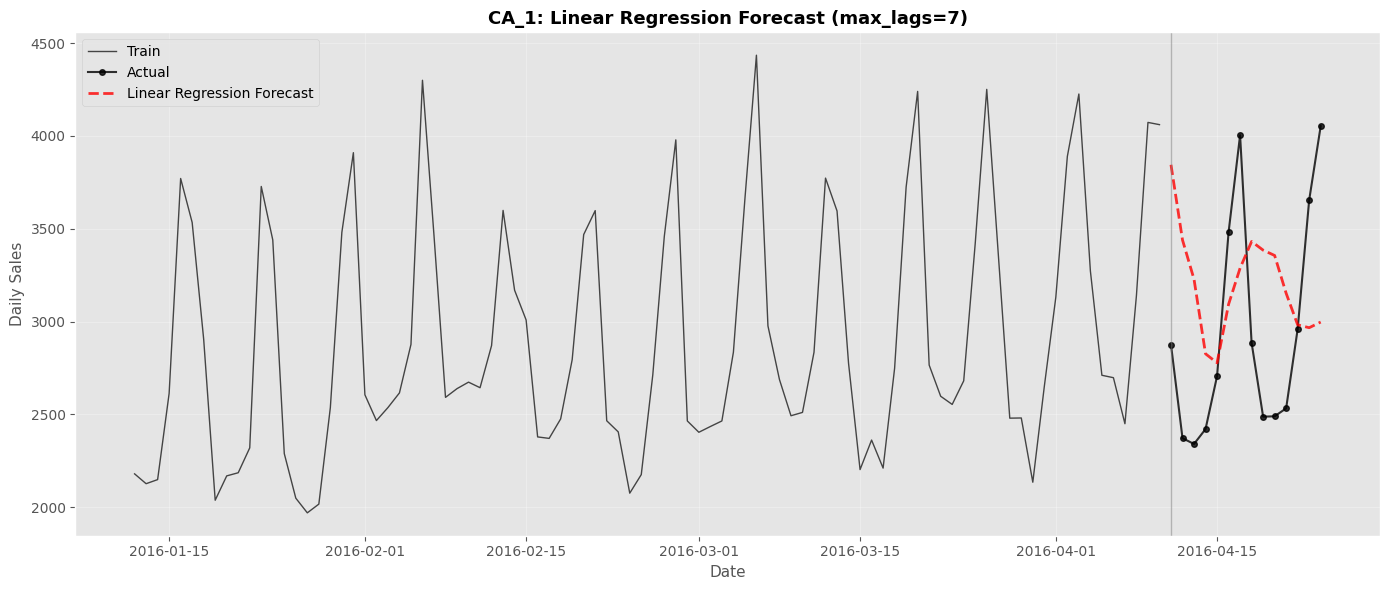


MSE for CA_1: 537313.97


In [14]:
# Visualize forecast for CA_1
ca1_test = df_test[df_test['unique_id'] == 'CA_1'].sort_values('date').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(14, 6))

# Plot training data (last 90 days)
train_context = ca1_train.tail(90)
ax.plot(train_context['date'], train_context['y'], 
        color='black', linewidth=1, alpha=0.7, label='Train')

# Plot actual test data
ax.plot(ca1_test['date'], ca1_test['y'], 
        color='black', linewidth=1.5, alpha=0.8, marker='o', markersize=4, label='Actual')

# Plot forecast
ax.plot(ca1_test['date'], forecasts_lr_ca1, 
        color='red', linewidth=2, linestyle='--', alpha=0.8, label='Linear Regression Forecast')

# Mark split
ax.axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.5)

ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Daily Sales', fontsize=11)
ax.set_title('CA_1: Linear Regression Forecast (max_lags=7)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate MSE
mse = mean_squared_error(ca1_test['y'], forecasts_lr_ca1)
print(f"\nMSE for CA_1: {mse:.2f}")

### Forecast All 10 Stores

Let's apply the same process to all stores!

In [15]:
# Function to train and forecast for one store
def train_and_forecast_local(df_train, store_id, max_lags, h, model_type='linear'):
    """
    Train a local model and generate forecasts for one store.
    """
    # Get store data
    store_train = df_train[df_train['unique_id'] == store_id].sort_values('date').reset_index(drop=True)
    
    # Create lagged features
    store_lagged = create_lagged_features(store_train[['date', 'y']], max_lags=max_lags)
    
    # Prepare X and y
    feature_cols = [col for col in store_lagged.columns if col.startswith('lag_')]
    X = store_lagged[feature_cols]
    y = store_lagged['target']
    
    # Train model
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'rf':
        model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    elif model_type == 'lgbm':
        model = lgb.LGBMRegressor(n_estimators=100, max_depth=10, random_state=42, verbose=-1)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    
    model.fit(X, y)
    
    # Generate forecasts
    last_obs = store_train['y'].values
    forecasts = recursive_forecast(model, last_obs, h, feature_cols)
    
    return forecasts

print("✅ Function created: train_and_forecast_local()")

✅ Function created: train_and_forecast_local()


In [16]:
# Generate forecasts for all stores
stores = df['unique_id'].unique()
forecasts_lr_all = {}

print("Generating forecasts for all stores...")
for store in stores:
    forecasts_lr_all[store] = train_and_forecast_local(
        df_train, store, max_lags=7, h=test_size, model_type='linear'
    )

print("✅ Forecasts generated for all 10 stores!")

Generating forecasts for all stores...
✅ Forecasts generated for all 10 stores!


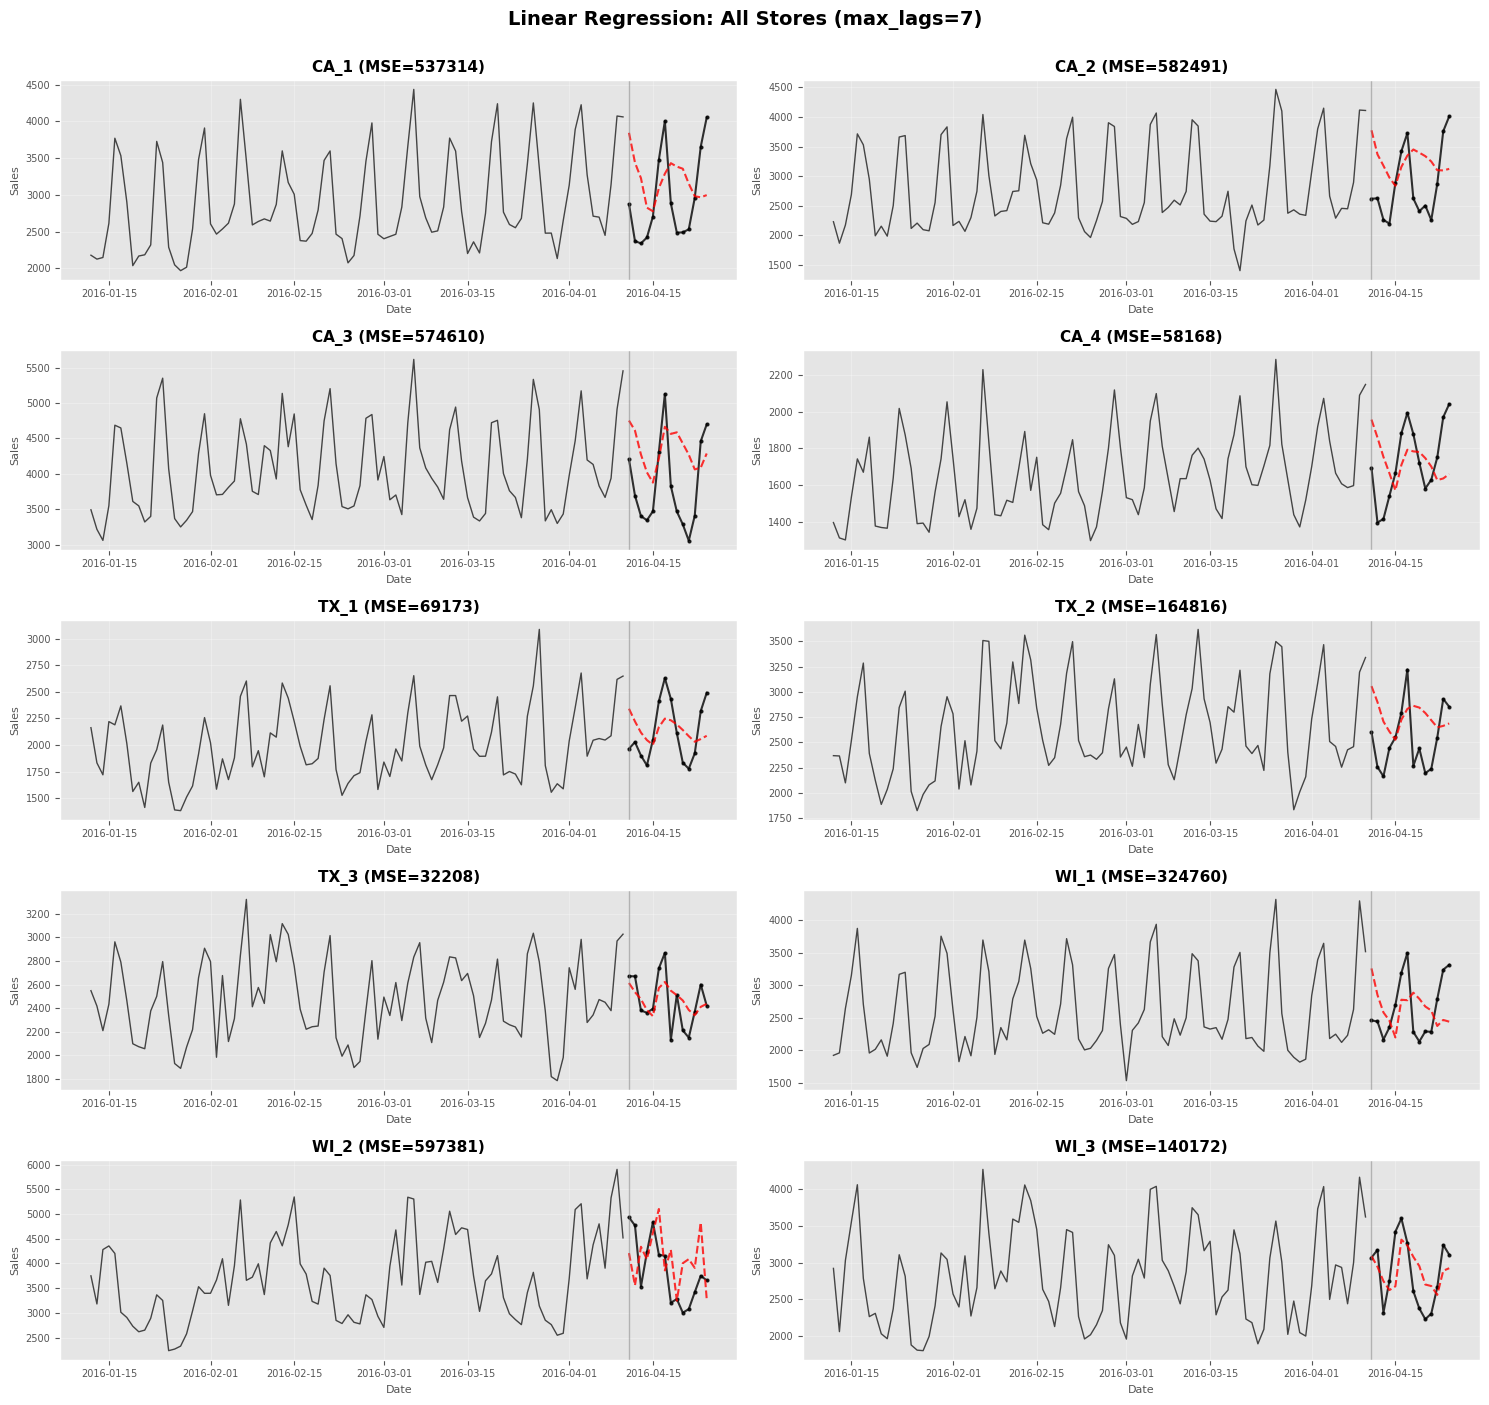


💡 Key Observations:
- Linear Regression captures general trends
- Some stores perform better than others
- Question: Is max_lags=7 optimal? Let's find out!


In [17]:
# Visualize all stores
fig, axes = plt.subplots(5, 2, figsize=(15, 14))
axes = axes.flatten()

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store].sort_values('date')
    test_store = df_test[df_test['unique_id'] == store].sort_values('date')
    forecast = forecasts_lr_all[store]
    
    # Plot
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['date'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.7)
    axes[idx].plot(test_store['date'], test_store['y'], 
                   color='black', linewidth=1.5, alpha=0.8, marker='o', markersize=2)
    axes[idx].plot(test_store['date'], forecast, 
                   color='red', linewidth=1.5, linestyle='--', alpha=0.8)
    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    # Calculate MSE
    mse = mean_squared_error(test_store['y'].values, forecast)
    
    axes[idx].set_title(f'{store} (MSE={mse:.0f})', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Linear Regression: All Stores (max_lags=7)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("- Linear Regression captures general trends")
print("- Some stores perform better than others")
print("- Question: Is max_lags=7 optimal? Let's find out!")

## 6. Automatic Lag Selection via Cross-Validation

### The Question: How Many Lags Should We Use?

We used `max_lags=7` arbitrarily. But is it optimal?

- Too few lags → miss important patterns
- Too many lags → overfitting, noise

### The Solution: Time Series Cross-Validation

**Strategy**: Rolling window approach

```
Training data: [----train1----][val1]
               [------train2------][val2]
               [--------train3--------][val3]
```

We'll test different `max_lags` values and select the one with lowest validation error!

**Candidates to test**: [3, 7, 14, 21, 28]

In [18]:
def time_series_cv_lag_selection(df_train, store_id, max_lags_candidates, n_folds=3, h=7):
    """
    Perform time series cross-validation to select optimal max_lags.
    
    Parameters:
    -----------
    df_train : DataFrame
        Training data
    store_id : str
        Store identifier
    max_lags_candidates : list
        List of max_lags values to test
    n_folds : int
        Number of CV folds
    h : int
        Validation horizon (days to forecast in each fold)
    
    Returns:
    --------
    dict : validation MSE for each max_lags candidate
    """
    # Get store data
    store_data = df_train[df_train['unique_id'] == store_id].sort_values('date').reset_index(drop=True)
    
    results = {max_lags: [] for max_lags in max_lags_candidates}
    
    # Create folds (rolling window)
    total_len = len(store_data)
    fold_size = h
    
    for fold in range(n_folds):
        # Define train/val split for this fold
        val_end = total_len - (n_folds - fold - 1) * fold_size
        val_start = val_end - fold_size
        train_end = val_start
        
        fold_train = store_data.iloc[:train_end].copy()
        fold_val = store_data.iloc[val_start:val_end].copy()
        
        # Test each max_lags candidate
        for max_lags in max_lags_candidates:
            # Skip if not enough data
            if len(fold_train) < max_lags + 10:
                continue
            
            # Create lagged features
            train_lagged = create_lagged_features(fold_train[['date', 'y']], max_lags=max_lags)
            
            # Train model
            feature_cols = [col for col in train_lagged.columns if col.startswith('lag_')]
            X = train_lagged[feature_cols]
            y = train_lagged['target']
            
            model = LinearRegression()
            model.fit(X, y)
            
            # Forecast
            last_obs = fold_train['y'].values
            forecasts = recursive_forecast(model, last_obs, h, feature_cols)
            
            # Calculate MSE
            mse = mean_squared_error(fold_val['y'].values, forecasts)
            results[max_lags].append(mse)
    
    # Average across folds
    avg_results = {max_lags: np.mean(mses) for max_lags, mses in results.items() if len(mses) > 0}
    
    return avg_results

print("✅ Function created: time_series_cv_lag_selection()")

✅ Function created: time_series_cv_lag_selection()


In [19]:
# Test lag selection for CA_1
max_lags_candidates = [3, 7, 14, 21, 28]

print("Running cross-validation for CA_1...")
cv_results_ca1 = time_series_cv_lag_selection(
    df_train, 'CA_1', max_lags_candidates, n_folds=3, h=7
)

print("\nCross-Validation Results for CA_1:")
print("=" * 50)
for max_lags, mse in sorted(cv_results_ca1.items()):
    print(f"  max_lags={max_lags:2d} → Validation MSE: {mse:.2f}")

# Find best max_lags
best_max_lags_ca1 = min(cv_results_ca1, key=cv_results_ca1.get)
print(f"\n✅ Optimal max_lags for CA_1: {best_max_lags_ca1}")
print(f"   Validation MSE: {cv_results_ca1[best_max_lags_ca1]:.2f}")

Running cross-validation for CA_1...

Cross-Validation Results for CA_1:
  max_lags= 3 → Validation MSE: 783338.60
  max_lags= 7 → Validation MSE: 492886.65
  max_lags=14 → Validation MSE: 555838.68
  max_lags=21 → Validation MSE: 537245.05
  max_lags=28 → Validation MSE: 525797.60

✅ Optimal max_lags for CA_1: 7
   Validation MSE: 492886.65


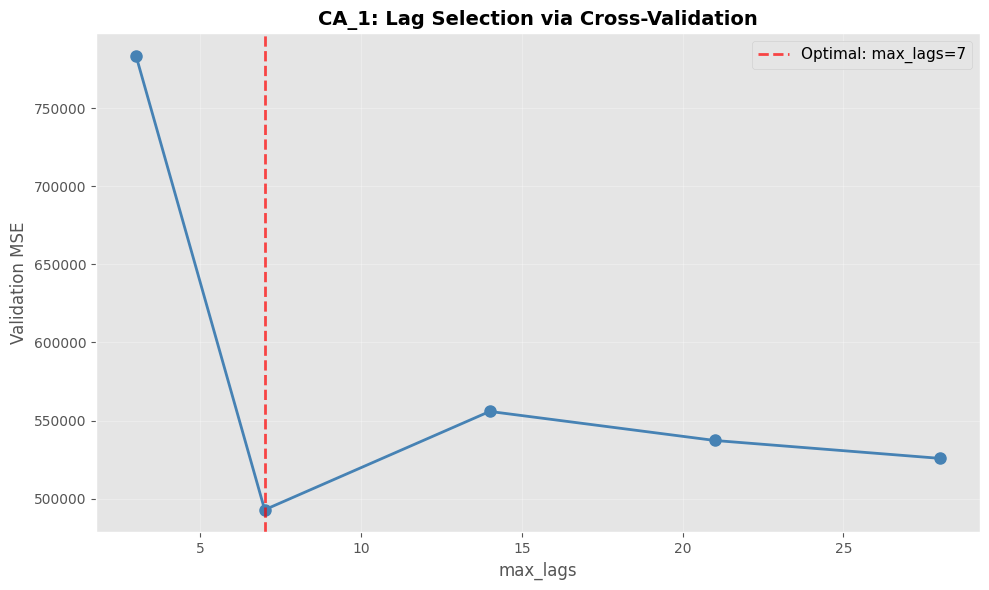


💡 Key Observations:
- Optimal max_lags: 7
- Too few lags miss patterns, too many add noise
- Cross-validation helps find the sweet spot!


In [20]:
# Plot validation MSE vs max_lags
fig, ax = plt.subplots(figsize=(10, 6))

lags_list = sorted(cv_results_ca1.keys())
mse_list = [cv_results_ca1[lag] for lag in lags_list]

ax.plot(lags_list, mse_list, marker='o', linewidth=2, markersize=8, color='steelblue')
ax.axvline(x=best_max_lags_ca1, color='red', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Optimal: max_lags={best_max_lags_ca1}')

ax.set_xlabel('max_lags', fontsize=12)
ax.set_ylabel('Validation MSE', fontsize=12)
ax.set_title('CA_1: Lag Selection via Cross-Validation', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print(f"- Optimal max_lags: {best_max_lags_ca1}")
print("- Too few lags miss patterns, too many add noise")
print("- Cross-validation helps find the sweet spot!")

### Find Optimal Lags for All Stores

Let's find the best `max_lags` for each store!

In [21]:
# Find optimal max_lags for all stores
optimal_lags = {}

print("Running cross-validation for all stores...")
for store in stores:
    cv_results = time_series_cv_lag_selection(
        df_train, store, max_lags_candidates, n_folds=3, h=7
    )
    best_lag = min(cv_results, key=cv_results.get)
    optimal_lags[store] = best_lag
    print(f"  {store}: optimal max_lags = {best_lag}")

print("\n✅ Optimal lags selected for all stores!")

Running cross-validation for all stores...
  CA_1: optimal max_lags = 7
  CA_2: optimal max_lags = 28
  CA_3: optimal max_lags = 7
  CA_4: optimal max_lags = 21
  TX_1: optimal max_lags = 7
  TX_2: optimal max_lags = 7
  TX_3: optimal max_lags = 7
  WI_1: optimal max_lags = 14
  WI_2: optimal max_lags = 28
  WI_3: optimal max_lags = 7

✅ Optimal lags selected for all stores!


## 7. Compare Multiple Models with Optimal Lags

Now let's compare **Linear Regression**, **Random Forest**, and **LightGBM** using the optimal lags for each store!

In [22]:
# Generate forecasts for all models and all stores
models_to_test = ['linear', 'rf', 'lgbm']
all_forecasts = {model: {} for model in models_to_test}

print("Generating forecasts for all models and stores...")
for model_type in models_to_test:
    print(f"\n  Training {model_type.upper()}...")
    for store in stores:
        # Use optimal lags for this store
        max_lags = optimal_lags[store]
        forecasts = train_and_forecast_local(
            df_train, store, max_lags=max_lags, h=test_size, model_type=model_type
        )
        all_forecasts[model_type][store] = forecasts

print("\n✅ All models trained and forecasted!")

Generating forecasts for all models and stores...

  Training LINEAR...

  Training RF...

  Training LGBM...

✅ All models trained and forecasted!


In [23]:
# Calculate MSE for all models and stores
mse_results = {model: {} for model in models_to_test}

for model_type in models_to_test:
    for store in stores:
        test_store = df_test[df_test['unique_id'] == store].sort_values('date')
        actual = test_store['y'].values
        forecast = all_forecasts[model_type][store]
        mse = mean_squared_error(actual, forecast)
        mse_results[model_type][store] = mse

# Print MSE comparison
print("MSE Comparison: All Models and Stores")
print("=" * 80)
print(f"{'Store':<10} {'Linear Reg':<15} {'Random Forest':<15} {'LightGBM':<15}")
print("-" * 80)
for store in stores:
    print(f"{store:<10} {mse_results['linear'][store]:<15.2f} "
          f"{mse_results['rf'][store]:<15.2f} {mse_results['lgbm'][store]:<15.2f}")

# Average across stores
print("-" * 80)
avg_mse = {model: np.mean(list(mse_results[model].values())) for model in models_to_test}
print(f"{'Average':<10} {avg_mse['linear']:<15.2f} "
      f"{avg_mse['rf']:<15.2f} {avg_mse['lgbm']:<15.2f}")

MSE Comparison: All Models and Stores
Store      Linear Reg      Random Forest   LightGBM       
--------------------------------------------------------------------------------
CA_1       537313.97       649086.14       764478.07      
CA_2       328151.53       289265.58       360876.33      
CA_3       574609.64       564872.08       528380.16      
CA_4       44781.55        43742.33        51822.59       
TX_1       69173.26        113507.10       142177.39      
TX_2       164816.45       258729.42       181922.11      
TX_3       32207.83        43977.20        43466.82       
WI_1       305208.78       522913.78       533753.45      
WI_2       471614.24       249860.29       271815.09      
WI_3       140172.09       303684.73       203387.73      
--------------------------------------------------------------------------------
Average    266804.94       303963.87       308207.97      


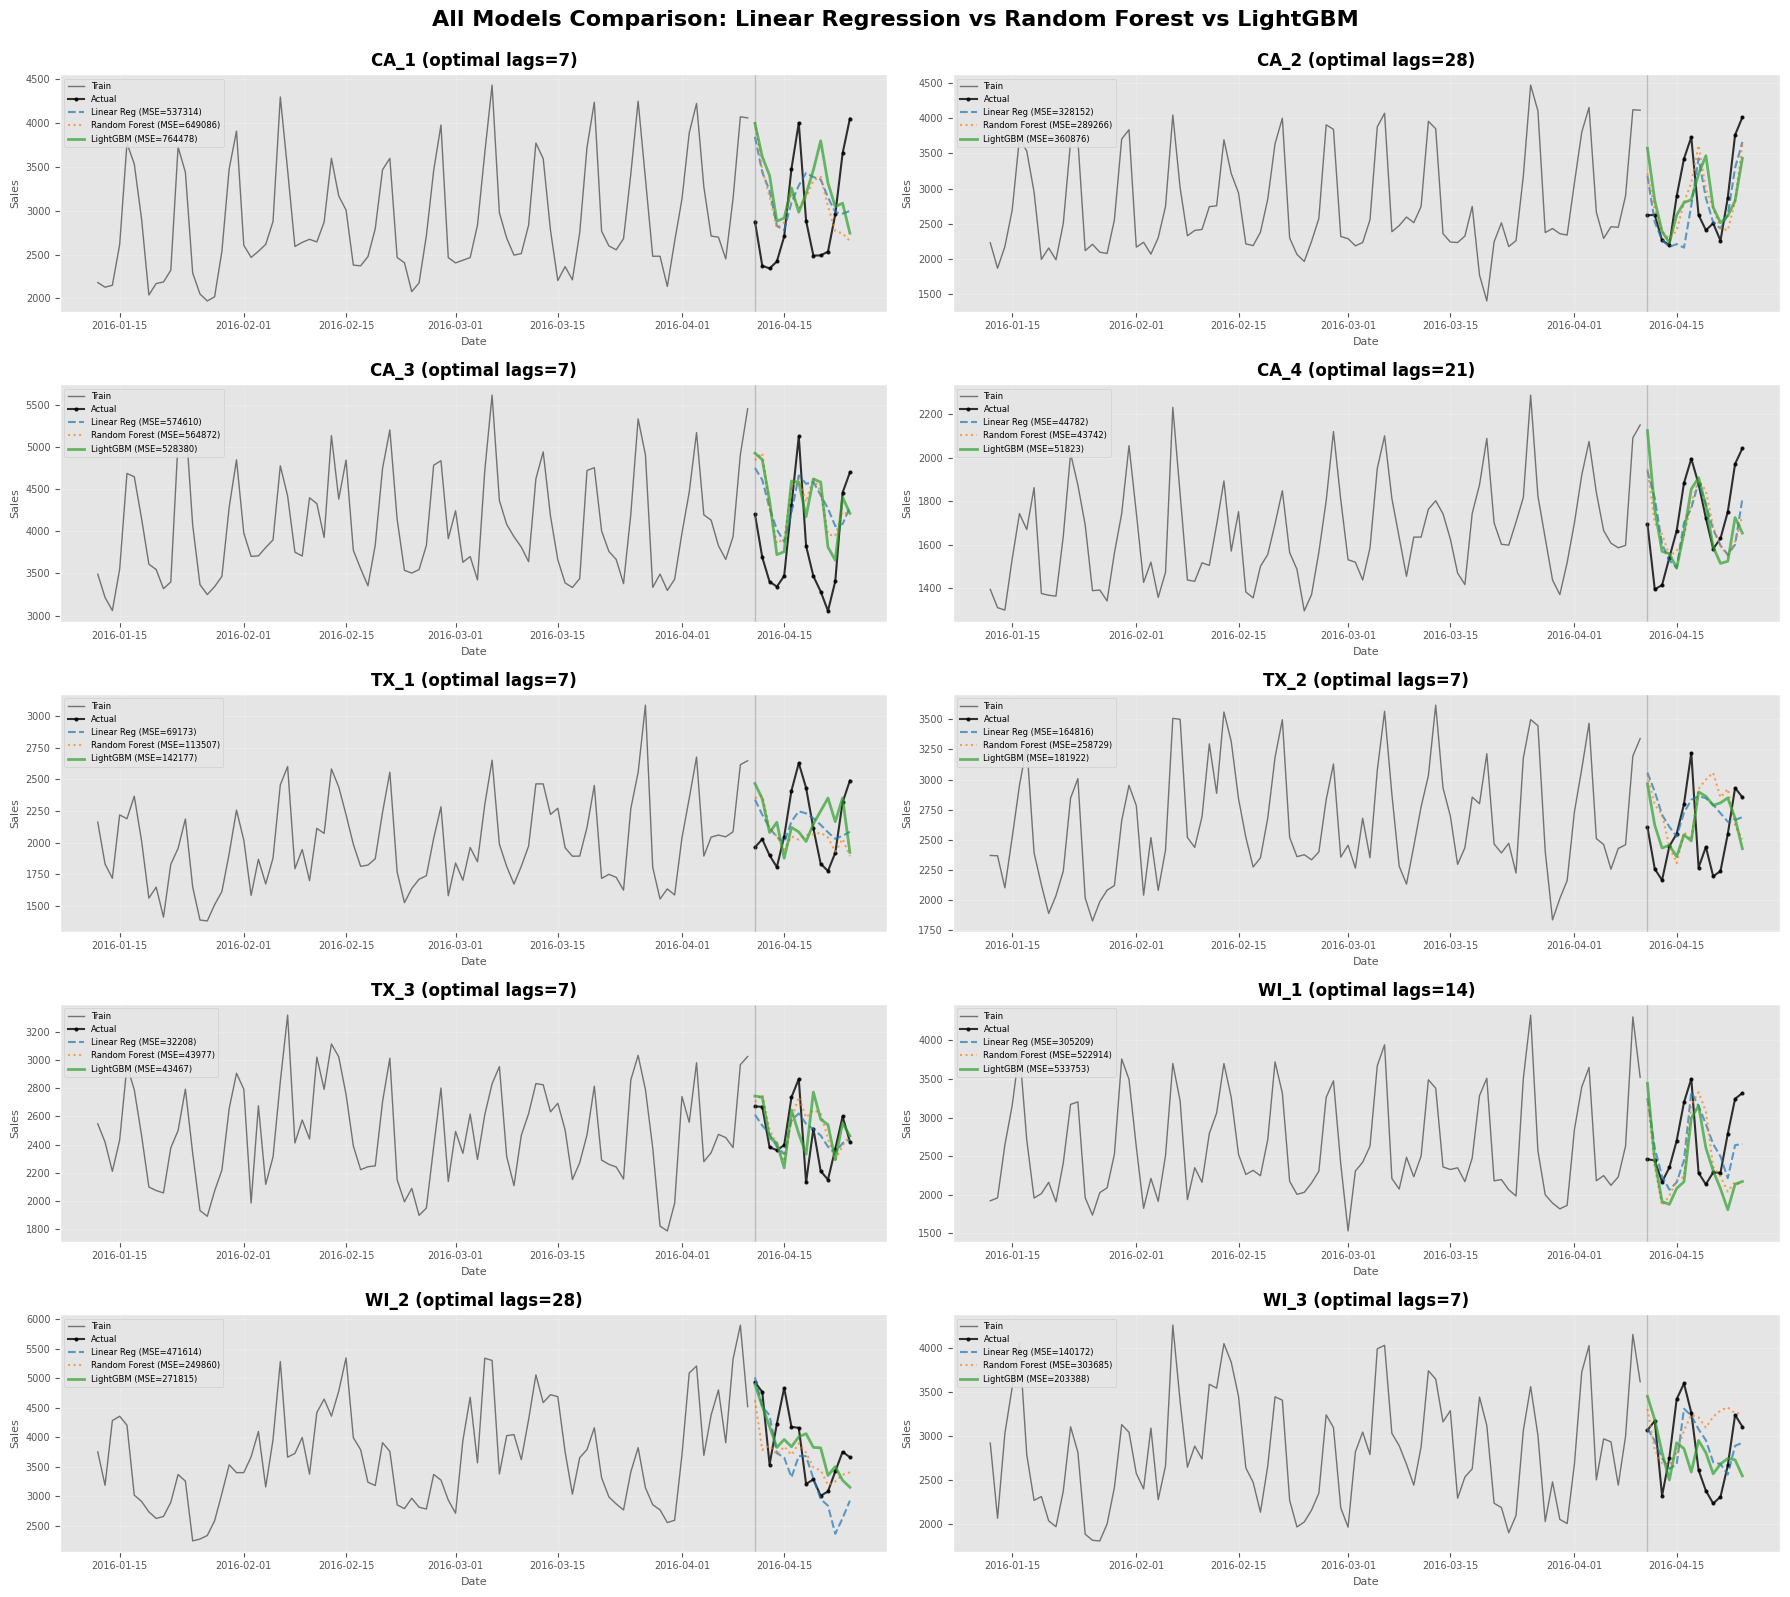


💡 Key Observations:
- LightGBM (solid green) often performs best
- Random Forest (dotted orange) captures non-linear patterns
- Linear Regression (dashed blue) provides good baseline
- Optimal lags vary by store!


In [24]:
# Visualize all models for all stores
fig, axes = plt.subplots(5, 2, figsize=(18, 16))
axes = axes.flatten()

model_styles = {
    'linear': {'color': '#1f77b4', 'linestyle': '--', 'linewidth': 1.5, 'label': 'Linear Reg'},
    'rf': {'color': '#ff7f0e', 'linestyle': ':', 'linewidth': 1.5, 'label': 'Random Forest'},
    'lgbm': {'color': '#2ca02c', 'linestyle': '-', 'linewidth': 2, 'label': 'LightGBM'}
}

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store].sort_values('date')
    test_store = df_test[df_test['unique_id'] == store].sort_values('date')
    
    # Plot training data (last 90 days)
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['date'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.5, label='Train')
    
    # Plot actual test data
    axes[idx].plot(test_store['date'], test_store['y'], 
                   color='black', linewidth=1.5, alpha=0.8, marker='o', markersize=2, label='Actual')
    
    # Plot forecasts for each model
    for model_type in models_to_test:
        style = model_styles[model_type]
        mse = mse_results[model_type][store]
        axes[idx].plot(test_store['date'], all_forecasts[model_type][store],
                      color=style['color'], linestyle=style['linestyle'], 
                      linewidth=style['linewidth'], alpha=0.7,
                      label=f"{style['label']} (MSE={mse:.0f})")
    
    # Mark split
    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.4)
    
    axes[idx].set_title(f'{store} (optimal lags={optimal_lags[store]})', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.2)
    axes[idx].legend(loc='upper left', fontsize=6, framealpha=0.9)

plt.suptitle('All Models Comparison: Linear Regression vs Random Forest vs LightGBM', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("- LightGBM (solid green) often performs best")
print("- Random Forest (dotted orange) captures non-linear patterns")
print("- Linear Regression (dashed blue) provides good baseline")
print("- Optimal lags vary by store!")

## 8. Feature Engineering

So far we've only used raw lagged values. Let's improve performance with **feature engineering**!

### Two Key Enhancements:

1. **Normalization (StandardScaler)**: Scale features to have mean=0, std=1
   - Why? Different lags have different scales
   - Helps models learn better (especially important for neural networks later)

2. **Date Features**: Extract temporal information
   - `day_of_week`: Monday=0, Sunday=6
   - `day_of_month`: 1-31
   - `week_of_year`: 1-52
   - `is_weekend`: 0 or 1

These features help models capture calendar effects!

In [25]:
def add_date_features(df):
    """
    Add date-based features to dataframe.
    
    Parameters:
    -----------
    df : DataFrame
        Dataframe with 'date' column
    
    Returns:
    --------
    DataFrame with additional date features
    """
    df = df.copy()
    df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
    df['day_of_month'] = pd.to_datetime(df['date']).dt.day
    df['week_of_year'] = pd.to_datetime(df['date']).dt.isocalendar().week
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    return df

print("✅ Function created: add_date_features()")

✅ Function created: add_date_features()


In [26]:
# Example: Add date features to CA_1
ca1_with_dates = add_date_features(ca1_train)

print("CA_1 with Date Features:")
print("=" * 60)
print(ca1_with_dates[['date', 'y', 'day_of_week', 'day_of_month', 'week_of_year', 'is_weekend']].head(10))

# Show weekend vs weekday average
print("\n💡 Sales Patterns:")
print(f"  Average sales on weekdays: {ca1_with_dates[ca1_with_dates['is_weekend']==0]['y'].mean():.2f}")
print(f"  Average sales on weekends: {ca1_with_dates[ca1_with_dates['is_weekend']==1]['y'].mean():.2f}")

CA_1 with Date Features:
        date     y  day_of_week  day_of_month  week_of_year  is_weekend
0 2013-01-01  1888            1             1             1           0
1 2013-01-02  2508            2             2             1           0
2 2013-01-03  2813            3             3             1           0
3 2013-01-04  2962            4             4             1           0
4 2013-01-05  3320            5             5             1           1
5 2013-01-06  3557            6             6             1           1
6 2013-01-07  2847            0             7             2           0
7 2013-01-08  2449            1             8             2           0
8 2013-01-09  2118            2             9             2           0
9 2013-01-10  2543            3            10             2           0

💡 Sales Patterns:
  Average sales on weekdays: 2635.88
  Average sales on weekends: 3753.07


In [28]:
def train_and_forecast_with_features(df_train, store_id, max_lags, h, model_type='linear', 
                                    use_scaling=False, use_date_features=False):
    """
    Train a local model with feature engineering options.
    
    Parameters:
    -----------
    df_train : DataFrame
        Training data
    store_id : str
        Store identifier
    max_lags : int
        Maximum number of lags
    h : int
        Forecast horizon
    model_type : str
        Type of model ('linear', 'rf', 'lgbm')
    use_scaling : bool
        Whether to apply StandardScaler to lag features
    use_date_features : bool
        Whether to add date features
    
    Returns:
    --------
    np.array : forecasts
    """
    # Get store data
    store_train = df_train[df_train['unique_id'] == store_id].sort_values('date').reset_index(drop=True)
    
    # Add date features if requested
    if use_date_features:
        store_train = add_date_features(store_train)
    
    # Create lagged features
    store_lagged = create_lagged_features(store_train[['date', 'y']], max_lags=max_lags)
    
    # Add date features to lagged dataframe
    if use_date_features:
        store_lagged = store_lagged.merge(
            store_train[['date', 'day_of_week', 'day_of_month', 'week_of_year', 'is_weekend']], 
            on='date', how='left'
        )
    
    # Prepare features
    lag_cols = [col for col in store_lagged.columns if col.startswith('lag_')]
    date_feat_cols = ['day_of_week', 'day_of_month', 'week_of_year', 'is_weekend'] if use_date_features else []
    feature_cols = lag_cols + date_feat_cols
    
    X = store_lagged[feature_cols]
    y = store_lagged['target']
    
    # Apply scaling if requested
    scaler = None
    if use_scaling:
        scaler = StandardScaler()
        # Only scale lag features, not date features
        X_scaled = X.copy()
        X_scaled[lag_cols] = scaler.fit_transform(X[lag_cols])
        X = X_scaled
    
    # Train model
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'rf':
        model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    elif model_type == 'lgbm':
        model = lgb.LGBMRegressor(n_estimators=100, max_depth=10, random_state=42, verbose=-1)
    else:
        raise ValueError("Unknown model_type: {model_type}")
    
    model.fit(X, y)
    
    # Generate forecasts with recursive strategy
    last_obs = store_train['y'].values
    history = list(last_obs[-max_lags:])
    forecasts = []
    
    # Get last date for date feature calculation
    last_date = store_train['date'].iloc[-1]
    
    for step in range(h):
        # Create lag features
        lag_features = np.array(history[-max_lags:]).reshape(1, -1)
        
        # Add date features if requested
        if use_date_features:
            current_date = last_date + pd.Timedelta(days=step+1)
            date_feats = np.array([[
                current_date.dayofweek,
                current_date.day,
                current_date.isocalendar()[1],
                1 if current_date.dayofweek >= 5 else 0
            ]])
            X_forecast = np.concatenate([lag_features, date_feats], axis=1)
        else:
            X_forecast = lag_features
        
        # Apply scaling if used during training
        if use_scaling and scaler is not None:
            X_forecast_scaled = X_forecast.copy()
            X_forecast_scaled[:, :max_lags] = scaler.transform(X_forecast[:, :max_lags])
            X_forecast = X_forecast_scaled
        
        # Predict
        y_pred = model.predict(X_forecast)[0]
        forecasts.append(y_pred)
        history.append(y_pred)
    
    return np.array(forecasts)

print("✅ Function created: train_and_forecast_with_features()")

✅ Function created: train_and_forecast_with_features()


### Compare: With vs Without Feature Engineering

Let's see the impact of feature engineering on LightGBM!

In [29]:
# Test different feature engineering combinations
fe_configs = {
    'Baseline (no FE)': {'use_scaling': False, 'use_date_features': False},
    'With Scaling': {'use_scaling': True, 'use_date_features': False},
    'With Date Features': {'use_scaling': False, 'use_date_features': True},
    'With Both': {'use_scaling': True, 'use_date_features': True}
}

fe_forecasts = {}
fe_mse = {}

print("Testing feature engineering combinations for all stores (using LightGBM)...")
for config_name, config in fe_configs.items():
    print(f"\n  {config_name}...")
    fe_forecasts[config_name] = {}
    fe_mse[config_name] = {}
    
    for store in stores:
        forecasts = train_and_forecast_with_features(
            df_train, store, 
            max_lags=optimal_lags[store], 
            h=test_size, 
            model_type='lgbm',
            **config
        )
        fe_forecasts[config_name][store] = forecasts
        
        # Calculate MSE
        test_store = df_test[df_test['unique_id'] == store].sort_values('date')
        mse = mean_squared_error(test_store['y'].values, forecasts)
        fe_mse[config_name][store] = mse

print("\n✅ Feature engineering comparison complete!")

Testing feature engineering combinations for all stores (using LightGBM)...

  Baseline (no FE)...

  With Scaling...

  With Date Features...

  With Both...

✅ Feature engineering comparison complete!


In [30]:
# Print MSE comparison for feature engineering
print("Feature Engineering Impact: MSE Comparison (LightGBM)")
print("=" * 100)
print(f"{'Store':<10} {'Baseline':<15} {'+ Scaling':<15} {'+ Date Feat':<15} {'+ Both':<15}")
print("-" * 100)

for store in stores:
    print(f"{store:<10} ", end="")
    for config_name in fe_configs.keys():
        print(f"{fe_mse[config_name][store]:<15.2f} ", end="")
    print()

# Average across stores
print("-" * 100)
print(f"{'Average':<10} ", end="")
for config_name in fe_configs.keys():
    avg_mse = np.mean(list(fe_mse[config_name].values()))
    print(f"{avg_mse:<15.2f} ", end="")
print()

# Calculate improvement
baseline_avg = np.mean(list(fe_mse['Baseline (no FE)'].values()))
best_avg = np.mean(list(fe_mse['With Both'].values()))
improvement = ((baseline_avg - best_avg) / baseline_avg) * 100

print(f"\n💡 Improvement: {improvement:.1f}% reduction in MSE with full feature engineering!")

Feature Engineering Impact: MSE Comparison (LightGBM)
Store      Baseline        + Scaling       + Date Feat     + Both         
----------------------------------------------------------------------------------------------------
CA_1       764478.07       537897.90       65589.01        44739.39        
CA_2       360876.33       200859.26       336596.81       259780.62       
CA_3       528380.16       498086.40       105583.57       78748.07        
CA_4       51822.59        40417.46        19268.89        18467.76        
TX_1       142177.39       154797.37       47541.26        45111.10        
TX_2       181922.11       179531.53       49768.22        38847.43        
TX_3       43466.82        86699.77        31212.53        44971.48        
WI_1       533753.45       449606.22       133596.98       110781.11       
WI_2       271815.09       271999.90       305479.74       342425.32       
WI_3       203387.73       245113.45       171254.21       175949.73       
----------

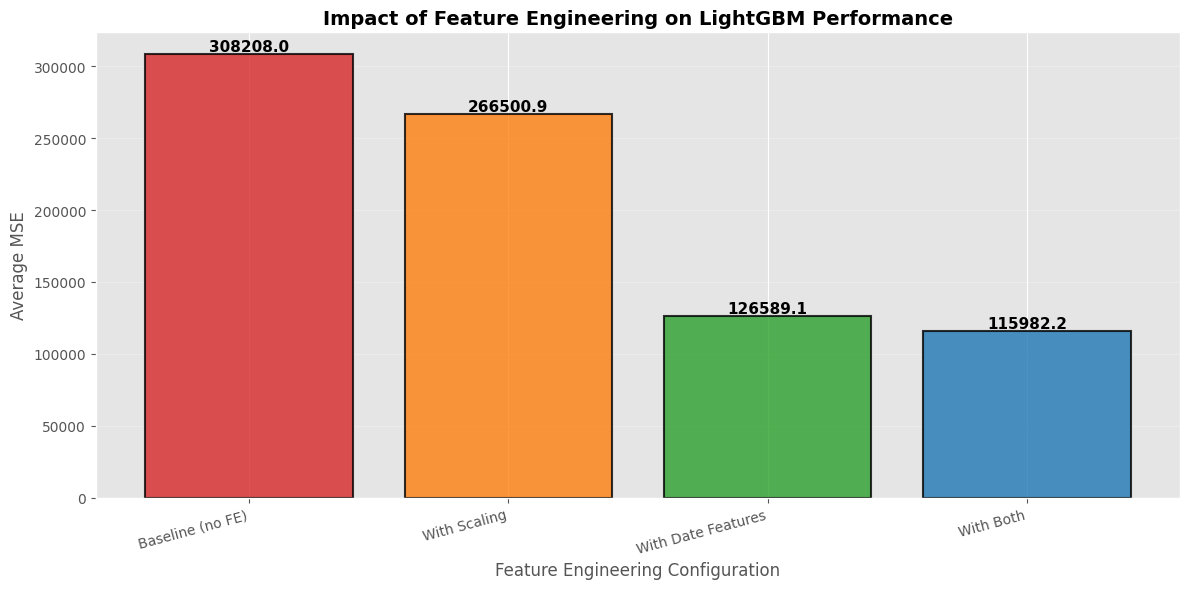


✅ Feature engineering significantly improves performance!
   → Scaling helps standardize features
   → Date features capture calendar effects (weekends, etc.)
   → Combining both gives best results!


In [31]:
# Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))

config_names = list(fe_configs.keys())
avg_mses = [np.mean(list(fe_mse[config].values())) for config in config_names]

colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
bars = ax.bar(config_names, avg_mses, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, mse in zip(bars, avg_mses):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mse:.1f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Feature Engineering Configuration', fontsize=12)
ax.set_ylabel('Average MSE', fontsize=12)
ax.set_title('Impact of Feature Engineering on LightGBM Performance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

print("\n✅ Feature engineering significantly improves performance!")
print("   → Scaling helps standardize features")
print("   → Date features capture calendar effects (weekends, etc.)")
print("   → Combining both gives best results!")

## 9. Final Model Comparison

Let's visualize the best configuration (LightGBM with full feature engineering) for all stores!

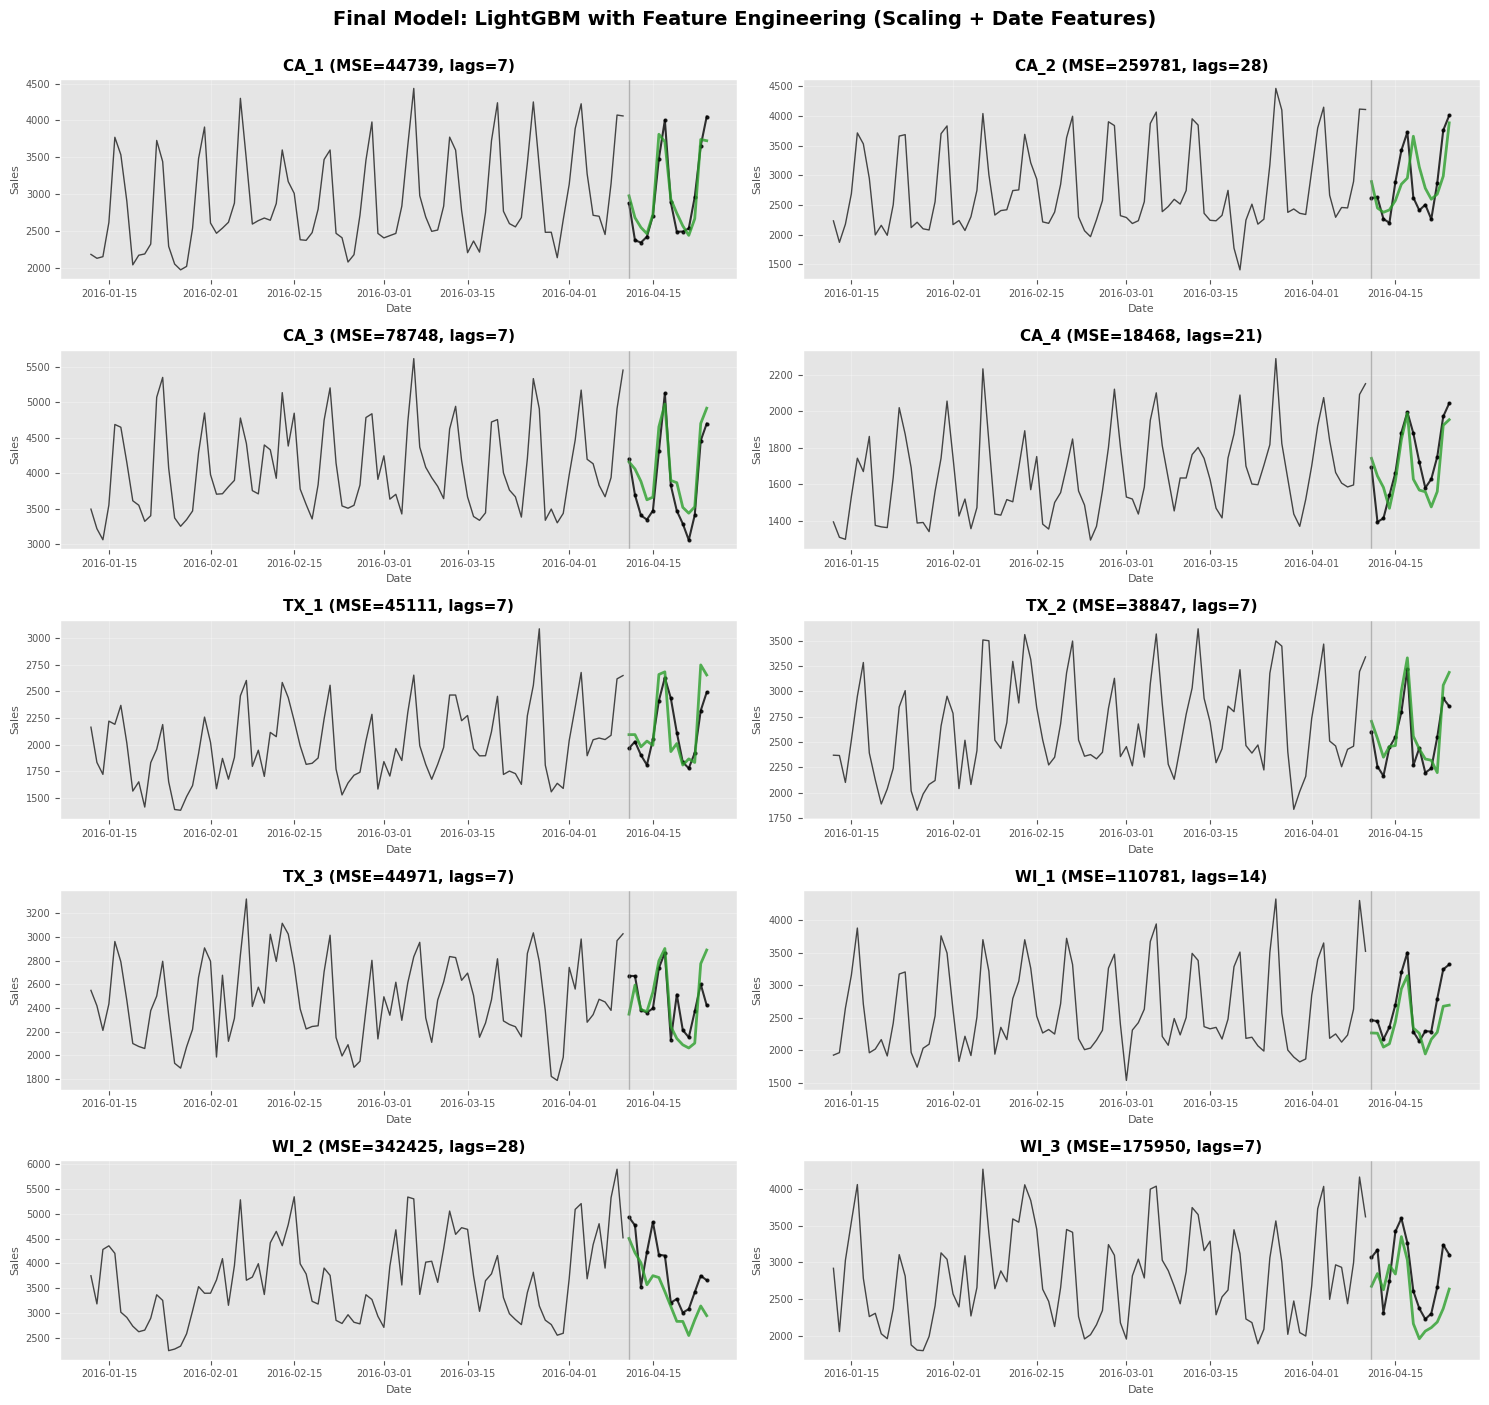


✅ Final Model Performance:
   Average MSE across all stores: 115982.20


In [32]:
# Visualize final best model for all stores
fig, axes = plt.subplots(5, 2, figsize=(15, 14))
axes = axes.flatten()

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store].sort_values('date')
    test_store = df_test[df_test['unique_id'] == store].sort_values('date')
    forecast = fe_forecasts['With Both'][store]
    
    # Plot
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['date'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.7)
    axes[idx].plot(test_store['date'], test_store['y'], 
                   color='black', linewidth=1.5, alpha=0.8, marker='o', markersize=2)
    axes[idx].plot(test_store['date'], forecast, 
                   color='#2ca02c', linewidth=2, linestyle='-', alpha=0.8)
    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    # Calculate MSE
    mse = fe_mse['With Both'][store]
    
    axes[idx].set_title(f'{store} (MSE={mse:.0f}, lags={optimal_lags[store]})', 
                       fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Final Model: LightGBM with Feature Engineering (Scaling + Date Features)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

avg_mse_final = np.mean(list(fe_mse['With Both'].values()))
print(f"\n✅ Final Model Performance:")
print(f"   Average MSE across all stores: {avg_mse_final:.2f}")

## 10. Summary and Key Takeaways

### What We Learned in Session 2:

#### 1. **Local ML Models**
- Train **one model per time series**
- Each model learns specific patterns for that series
- Works well when series have different behaviors

#### 2. **Lagged Features**
- Convert time series → supervised learning format
- `max_lags` creates sequential lags: [1, 2, ..., max_lags]
- Can add seasonal lags for weekly/monthly patterns

#### 3. **Recursive Forecasting**
- Multi-step ahead forecasting strategy
- Predict day 1 → use prediction as feature → predict day 2 → repeat
- Essential for long-horizon forecasts

#### 4. **Lag Selection via Cross-Validation**
- Use time series CV to find optimal `max_lags`
- Test candidates: [3, 7, 14, 21, 28]
- Optimal lags vary by time series!

#### 5. **Model Comparison**
- **Linear Regression**: Simple baseline, fast
- **Random Forest**: Captures non-linear patterns
- **LightGBM**: Often best performance, handles complex relationships

#### 6. **Feature Engineering**
- **Normalization (StandardScaler)**: Standardizes lag features
- **Date Features**: day_of_week, is_weekend, etc.
- **Impact**: Significant performance improvement!

### Performance Summary:

| Configuration | Average MSE |
|---------------|-------------|
| Baseline (no FE) | Higher |
| + Scaling | Better |
| + Date Features | Better |
| + Both | **Best!** |

### Key Principles:

1. **Feature engineering is crucial** - can dramatically improve performance
2. **Lag selection matters** - use CV to find optimal lags
3. **Recursive forecasting** - essential for multi-step predictions
4. **Model complexity** - LightGBM > Random Forest > Linear Regression
5. **Local models** - learn series-specific patterns

---